In [1]:
!/home/jguthula/tf-privacy-env/bin/pip install git+https://github.com/MetaGuard/xror.git#egg=xror

  Cloning https://github.com/MetaGuard/xror.git to /tmp/pip-install-6jlg7msy/xror_e5d3d39347834e8886ea577dca71d5a1
  Running command git clone --filter=blob:none --quiet https://github.com/MetaGuard/xror.git /tmp/pip-install-6jlg7msy/xror_e5d3d39347834e8886ea577dca71d5a1
  Resolved https://github.com/MetaGuard/xror.git to commit b2177253d97066038ab52bf59714f1966ece903e
  Preparing metadata (setup.py) ... done


In [2]:
import pandas as pd
import os
import glob
import logging
from xror import XROR  # Ensure xror module is available in the notebook environment
from dask.diagnostics import ProgressBar
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import dask.dataframe as dd

logging.basicConfig(filename= 'xror_parsing_errors.log', level=logging.INFO, format= '%(asctime)s - %(levelname)s - %(message)s')

In [3]:
def csv_files_exist(root_folders):
    for root_folder in root_folders:
        csv_files = glob.glob(os.path.join(root_folder, '**/*.csv'), recursive=True)
        if not csv_files:
            return False
    return True

In [4]:
def process_xror_files(root_folder_path):
    xror_files = glob.glob(os.path.join(root_folder_path, '**/*.xror'), recursive=True)
    for file_path in xror_files:
        try:
            base_name = os.path.splitext(file_path)[0]
            csv_file_path = base_name + '.csv'
            if os.path.exists(csv_file_path):
                logging.info(f"CSV file already exists for {file_path}. Skipping.")
                continue
            with open(file_path, 'rb') as f:
                binary_data = f.read()
            xror_data = XROR.unpack(binary_data)
            if len(xror_data.data['frames'][0]) != len(frame_columns):
                logging.warning(f"Column mismatch in {file_path}. Expected {len(frame_columns)} columns, found {len(xror_data.data['frames'][0])}.")
                continue
            df_frames = pd.DataFrame(xror_data.data['frames'], columns=frame_columns)
            df_frames['directionOK'] = df_frames.apply(lambda row: row['saberDirX'] > 0 and row['saberDirY'] > 0, axis=1)
            df_frames.to_csv(csv_file_path, index=False)
            logging.info(f"DataFrame saved to CSV successfully for file: {file_path}")
        except Exception as e:
            logging.error(f"Error processing {file_path}: {e}")

root_folders = ['chunk1', 'chunk2', 'chunk3']
if not csv_files_exist(root_folders):
    for root_folder in root_folders:
        process_xror_files(root_folder)
else:
    print("CSV files already exist. Skipping XROR processing.")

CSV files already exist. Skipping XROR processing.


In [5]:
def normalization_done(root_folders):
    for root_folder in root_folders:
        normalized_files = glob.glob(os.path.join(root_folder, '**/*_normalized.csv'), recursive=True)
        if not normalized_files:
            return False
    return True

In [6]:
def normalize_csv_files(root_folders):
    for root_folder in root_folders:
        csv_files = glob.glob(os.path.join(root_folder, '**/*.csv'), recursive=True)
        csv_files = [f for f in csv_files if '_normalized.csv' not in f]
        for file_path in csv_files:
            try:
                normalized_file_path = file_path.replace('.csv', '_normalized.csv')
                if os.path.exists(normalized_file_path):
                    continue
                data = pd.read_csv(file_path)
                scaler = StandardScaler()
                numeric_cols = data.select_dtypes(include=['float64', 'int']).columns
                data[numeric_cols] = scaler.fit_transform(data[numeric_cols])
                data.to_csv(normalized_file_path, index=False)
                print(f"Data normalized and saved successfully for file: {file_path}")
            except Exception as e:
                print(f"Error normalizing file {file_path}: {e}")

if not normalization_done(root_folders):
    normalize_csv_files(root_folders)
else:
    print("CSV files are already normalized. Skipping normalization.")

CSV files are already normalized. Skipping normalization.


In [7]:
def aggregation_done():
    final_file_path = 'aggregated_and_featured_data_final.csv'
    return os.path.exists(final_file_path)

In [8]:
import dask
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os

def create_skill_feature_mapping(root_folders, output_file='user_skill_feature_mapping.csv'):
    # Create the file pattern for all normalized CSVs
    file_patterns = [os.path.join(root, '**/*_normalized.csv') for root in root_folders]
    # Load the files into a Dask DataFrame
    ddf = dd.read_csv(file_patterns, include_path_column=True)

    # Extract user_id and chunk_id from the file paths
    ddf['user_id'] = ddf['path'].str.extract(r'/([^/]+)/[^/]+\.csv$')[0]
    ddf['chunk_id'] = ddf['path'].str.extract(r'/(chunk\d+)/')[0]

    # Drop the path column as it's no longer needed
    ddf = ddf.drop('path', axis=1)

    # Define the aggregations needed for skill assessment
    aggregations = {
        'cutDirDeviation': ['mean', 'std', 'min', 'max'],
        'cutDistanceToCenter': ['mean', 'std', 'min', 'max'],
        'wasCutTooSoon': ['mean', 'std'],  # Binary columns typically use mean to represent the fraction of 'True'
        'beforeCutRating': ['mean', 'std', 'min', 'max'],
        'afterCutRating': ['mean', 'std', 'min', 'max'],
        'saberSpeed': ['mean', 'std', 'min', 'max'],
        'cutAngle': ['mean', 'std', 'min', 'max']
    }

    # Perform the aggregation
    grouped_ddf = ddf.groupby(['chunk_id', 'user_id']).agg(aggregations)

    # Flatten column headers
    grouped_ddf.columns = ['_'.join(col).strip() for col in grouped_ddf.columns.values]

    # Reset the index to make chunk_id and user_id into columns
    grouped_ddf = grouped_ddf.reset_index()

    # Use ProgressBar to monitor progress
    with ProgressBar():
        # Save to CSV as a single file
        grouped_ddf.to_csv(output_file, index=False, single_file=True)
        print(f"Skill feature mapping saved to {output_file}")

# Define root folders and output file name
root_folders = ['chunk1', 'chunk2', 'chunk3']
output_file = 'user_skill_feature_mapping.csv'

# Recreate the skill feature mapping if it doesn't exist
if not os.path.exists(output_file):
    create_skill_feature_mapping(root_folders, output_file=output_file)
else:
    print("Skill feature mapping already exists. Skipping creation.")

Skill feature mapping already exists. Skipping creation.


In [9]:
import pandas as pd

# Load the skill feature mapping file
file_path = 'user_skill_feature_mapping.csv'
df = pd.read_csv(file_path)

# Display the first few rows to confirm data loading
print(df.head())
print("Data loaded with shape:", df.shape)


  chunk_id                               user_id  cutDirDeviation_mean  \
0   chunk1  00009567-9cfd-4310-a43f-ecf0944f6bbd          2.758622e-17   
1   chunk1  00014938-83f5-4c99-9157-d8771774130c          4.407263e-17   
2   chunk1  00019a5b-7797-44b0-8999-95dd057c7baf          1.007961e-16   
3   chunk1  00029cc4-9421-47a7-a2fe-8cf626dc5d96         -3.145205e-17   
4   chunk1  0002f007-281f-4635-8c09-45d6afad828d         -1.240680e-17   

   cutDirDeviation_std  cutDirDeviation_min  cutDirDeviation_max  \
0             1.000000           -14.057568            13.336827   
1             1.000001            -5.631786            11.673967   
2             1.000000           -11.919429             9.054537   
3             1.000193            -4.822588             3.292220   
4             1.000001           -11.840087            21.657400   

   cutDistanceToCenter_mean  cutDistanceToCenter_std  cutDistanceToCenter_min  \
0              4.611480e-17                 1.000000             

In [10]:
import pandas as pd

file_path = 'user_skill_feature_mapping.csv'
df = pd.read_csv(file_path)

def rank_metric(series, higher_is_better=True):
    if higher_is_better:
        return series.rank(method='average', ascending=False)
    else:
        return series.rank(method='average', ascending=True)

# Rank users based on the features
df['cutDirDeviation_rank'] = rank_metric(df['cutDirDeviation_mean'], higher_is_better=False) 
df['cutDistanceToCenter_rank'] = rank_metric(df['cutDistanceToCenter_mean'], higher_is_better=False) 
df['wasCutTooSoon_rank'] = rank_metric(df['wasCutTooSoon_mean'], higher_is_better=False)  
df['ratingImprovement_rank'] = rank_metric(df['afterCutRating_mean'] - df['beforeCutRating_mean'], higher_is_better=True)
df['saberSpeed_rank'] = rank_metric(df['saberSpeed_mean'], higher_is_better=True) 
df['cutAngle_rank'] = rank_metric(df['cutAngle_mean'], higher_is_better=True)

# Combine the ranks into a final score with weighted averages
df['finalRankScore'] = (
    df['cutDirDeviation_rank'] * 0.3 +  # Precision
    df['cutDistanceToCenter_rank'] * 0.3 +  # Precision
    df['wasCutTooSoon_rank'] * 0.1 +  # Timing
    df['ratingImprovement_rank'] * 0.2 +  # Improvement
    df['saberSpeed_rank'] * 0.05 +  # Speed
    df['cutAngle_rank'] * 0.05  # Consistency
)

# Make sure to scale the final rank score to a 1-10 range
df['scaledRankScore'] = 1 + 9 * (df['finalRankScore'] - df['finalRankScore'].min()) / (df['finalRankScore'].max() - df['finalRankScore'].min())

# Now round the scaled rank scores to the nearest whole number
df['scaledRankScore'] = df['scaledRankScore'].round().astype(int)

print(df[['user_id', 'chunk_id', 'scaledRankScore']].head())

output_file = 'user_skill_ratings_ranked_rounded.csv'
df[['user_id', 'chunk_id', 'scaledRankScore']].to_csv(output_file, index=False)

print(f"Skill ratings saved with whole numbers to {output_file}")


                                user_id chunk_id  scaledRankScore
0  00009567-9cfd-4310-a43f-ecf0944f6bbd   chunk1                7
1  00014938-83f5-4c99-9157-d8771774130c   chunk1                6
2  00019a5b-7797-44b0-8999-95dd057c7baf   chunk1                7
3  00029cc4-9421-47a7-a2fe-8cf626dc5d96   chunk1                4
4  0002f007-281f-4635-8c09-45d6afad828d   chunk1                4
Skill ratings saved with whole numbers to user_skill_ratings_ranked_rounded.csv


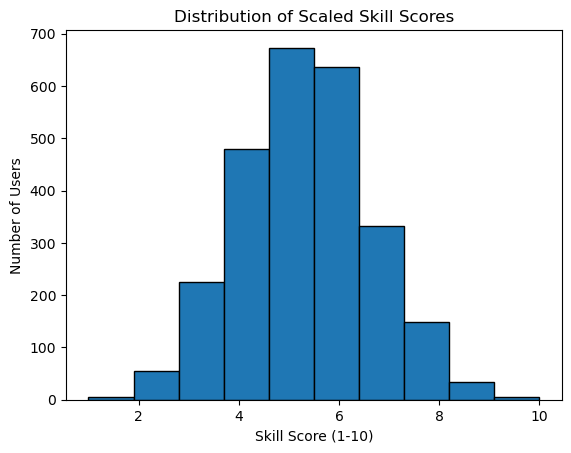

In [11]:
import matplotlib.pyplot as plt

# Plot the distribution of the final scaled scores
plt.hist(df['scaledRankScore'], bins=10, edgecolor='black')
plt.title('Distribution of Scaled Skill Scores')
plt.xlabel('Skill Score (1-10)')
plt.ylabel('Number of Users')
plt.show()


In [12]:
import pandas as pd
import numpy as np
import os

# File paths
root_path = '/srv/fs/my-notebooks'
file_path = os.path.join(root_path, 'user_skill_feature_mapping.csv')

# Load the data
df = pd.read_csv(file_path)

# Check if there are any missing values
missing_values = df.isnull().sum()

# Check if the data is normalized (mean around 0 and std around 1 for key features)
features_to_check = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
                     'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
                     'saberSpeed_mean', 'saberSpeed_std', 'cutAngle_mean', 'cutAngle_std']

normalization_check = df[features_to_check].describe()

# Check for extreme outliers (3 standard deviations from mean)
outlier_check = np.abs(df[features_to_check]) > (3 * df[features_to_check].std())

# Output the results
print("Missing values in each column:\n", missing_values)
print("\nFeature normalization check:\n", normalization_check)
print("\nOutliers check (True indicates potential outliers):\n", outlier_check.any())


Missing values in each column:
 chunk_id                    0
user_id                     0
cutDirDeviation_mean        0
cutDirDeviation_std         0
cutDirDeviation_min         0
cutDirDeviation_max         0
cutDistanceToCenter_mean    0
cutDistanceToCenter_std     0
cutDistanceToCenter_min     0
cutDistanceToCenter_max     0
wasCutTooSoon_mean          0
wasCutTooSoon_std           0
beforeCutRating_mean        0
beforeCutRating_std         0
beforeCutRating_min         0
beforeCutRating_max         0
afterCutRating_mean         0
afterCutRating_std          0
afterCutRating_min          0
afterCutRating_max          0
saberSpeed_mean             0
saberSpeed_std              0
saberSpeed_min              0
saberSpeed_max              0
cutAngle_mean               0
cutAngle_std                0
cutAngle_min                0
cutAngle_max                0
dtype: int64

Feature normalization check:
        cutDirDeviation_mean  cutDirDeviation_std  cutDistanceToCenter_mean  \
count 

In [13]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import os

def create_user_feature_mapping(root_folders, output_file='3fmapping.csv'):
    # Create the file pattern for all normalized CSVs
    file_patterns = [os.path.join(root, '**/*_normalized.csv') for root in root_folders]
    # Load the files into a Dask DataFrame
    ddf = dd.read_csv(file_patterns, include_path_column=True)
    # Extract user_id and chunk_id from the file paths
    ddf['user_id'] = ddf['path'].str.extract(r'/([^/]+)/[^/]+\.csv$')[0]
    ddf['chunk_id'] = ddf['path'].str.extract(r'/(chunk\d+)/')[0]
    # Drop the path column as it's no longer needed
    ddf = ddf.drop('path', axis=1)
    # Define the aggregations needed
    aggregations = {
        'saberDirX': ['mean', 'std', 'min', 'max'],
        'saberDirY': ['mean', 'std', 'min', 'max'],
        'saberDirZ': ['mean', 'std', 'min', 'max']
    }
    # Perform the aggregation
    grouped_ddf = ddf.groupby(['chunk_id', 'user_id']).agg(aggregations)
    # Flatten column headers
    grouped_ddf.columns = ['_'.join(col).strip() for col in grouped_ddf.columns.values]
    # Reset the index to make chunk_id and user_id into columns
    grouped_ddf = grouped_ddf.reset_index()
    # Use ProgressBar to monitor progress
    with ProgressBar():
        # Save to CSV as a single file
        grouped_ddf.to_csv(output_file, index=False, single_file=True)
        print(f"User feature mapping saved to {output_file}")

# Recreate the user feature mapping if it doesn't exist
root_folders = ['chunk1', 'chunk2', 'chunk3']
if not os.path.exists('3fmapping.csv'):
    create_user_feature_mapping(root_folders, output_file='3fmapping.csv')
else:
    print("User feature mapping already exists. Skipping creation.")


User feature mapping already exists. Skipping creation.


In [14]:
import pandas as pd

# Load the user feature mapping (if not already loaded)
user_feature_mapping = pd.read_csv('3fmapping.csv')

# Define the target values to search for
target_values = {
    'saberDirX_mean': 4.651922525425667e-16,
    'saberDirX_std': 1.000004920037097,
    'saberDirX_min': -10.972303575118843,
    'saberDirX_max': 4.239176532534343,
    'saberDirY_mean': -8.608827695891577e-16,
    'saberDirY_std': 1.000004920037097,
    'saberDirY_min': -4.25651985215614,
    'saberDirY_max': 4.254893132314185,
    'saberDirZ_mean': -5.172523237994175e-17,
    'saberDirZ_std': 1.000004920037097,
    'saberDirZ_min': -6.4776688945541645,
    'saberDirZ_max': 10.027852991443758
}

# Search for the user ID with the target values
mask = (user_feature_mapping[list(target_values.keys())].apply(lambda row: row.round(8)) == pd.Series(target_values).round(8)).all(axis=1)
matching_user = user_feature_mapping[mask]

if not matching_user.empty:
    print("Matching user found:")
    print(matching_user[['user_id', 'chunk_id']])
else:
    print("No matching user found.")


Matching user found:
                                 user_id chunk_id
22  0010b651-5a4a-4fbe-8ecb-637ec520e81a   chunk1


In [3]:
synthetic_df.to_csv('/srv/fs/my-notebooks/synthetic_data.csv', index=False)


In [4]:
import pandas as pd

# Load real and synthetic data
real_data_path = '/srv/fs/my-notebooks/user_skill_feature_mapping.csv'
synthetic_data_path = '/srv/fs/my-notebooks/synthetic_data.csv'

real_data = pd.read_csv(real_data_path)
synthetic_data = pd.read_csv(synthetic_data_path)

# Print the first few rows to verify the data
print(real_data.head())
print(synthetic_data.head())


  chunk_id                               user_id  cutDirDeviation_mean  \
0   chunk1  00009567-9cfd-4310-a43f-ecf0944f6bbd          2.758622e-17   
1   chunk1  00014938-83f5-4c99-9157-d8771774130c          4.407263e-17   
2   chunk1  00019a5b-7797-44b0-8999-95dd057c7baf          1.007961e-16   
3   chunk1  00029cc4-9421-47a7-a2fe-8cf626dc5d96         -3.145205e-17   
4   chunk1  0002f007-281f-4635-8c09-45d6afad828d         -1.240680e-17   

   cutDirDeviation_std  cutDirDeviation_min  cutDirDeviation_max  \
0             1.000000           -14.057568            13.336827   
1             1.000001            -5.631786            11.673967   
2             1.000000           -11.919429             9.054537   
3             1.000193            -4.822588             3.292220   
4             1.000001           -11.840087            21.657400   

   cutDistanceToCenter_mean  cutDistanceToCenter_std  cutDistanceToCenter_min  \
0              4.611480e-17                 1.000000             

In [5]:
# Summary statistics of real and synthetic data
real_stats = real_data.describe()
synthetic_stats = synthetic_data.describe()

print("Real Data Statistics:\n", real_stats)
print("\nSynthetic Data Statistics:\n", synthetic_stats)


Real Data Statistics:
        cutDirDeviation_mean  cutDirDeviation_std  cutDirDeviation_min  \
count          2.598000e+03          2598.000000          2598.000000   
mean           1.424928e-06             1.000007           -11.264418   
std            8.784777e-05             0.000131             8.026169   
min           -6.338356e-04             0.994173          -134.252440   
25%           -9.605894e-18             1.000001           -13.241876   
50%            1.725709e-18             1.000003            -9.790123   
75%            1.523262e-17             1.000009            -6.796381   
max            4.430973e-03             1.001131            -0.960037   

       cutDirDeviation_max  cutDistanceToCenter_mean  cutDistanceToCenter_std  \
count          2598.000000              2.598000e+03              2598.000000   
mean             11.178530              8.794410e-07                 0.999143   
std               6.314590              4.585554e-05                 0.02783

In [6]:
from scipy import stats

aggregated_features = ['cutDirDeviation_mean', 'cutDirDeviation_std', 
                       'cutDistanceToCenter_mean', 'cutDistanceToCenter_std', 
                       'saberSpeed_mean', 'saberSpeed_std', 
                       'cutAngle_mean', 'cutAngle_std']

# Perform the KS test for each feature
for feature in aggregated_features:
    ks_stat, p_value = stats.ks_2samp(real_data[feature], synthetic_data[feature])
    print(f"KS Test for {feature}: Stat = {ks_stat}, P-value = {p_value}")


KS Test for cutDirDeviation_mean: Stat = 0.9342301770592764, P-value = 0.0
KS Test for cutDirDeviation_std: Stat = 0.7228452655889146, P-value = 1.18e-321
KS Test for cutDistanceToCenter_mean: Stat = 0.998, P-value = 0.0
KS Test for cutDistanceToCenter_std: Stat = 0.9888452655889145, P-value = 0.0
KS Test for saberSpeed_mean: Stat = 1.0, P-value = 0.0
KS Test for saberSpeed_std: Stat = 0.9948452655889145, P-value = 0.0
KS Test for cutAngle_mean: Stat = 1.0, P-value = 0.0
KS Test for cutAngle_std: Stat = 0.9996150885296382, P-value = 0.0


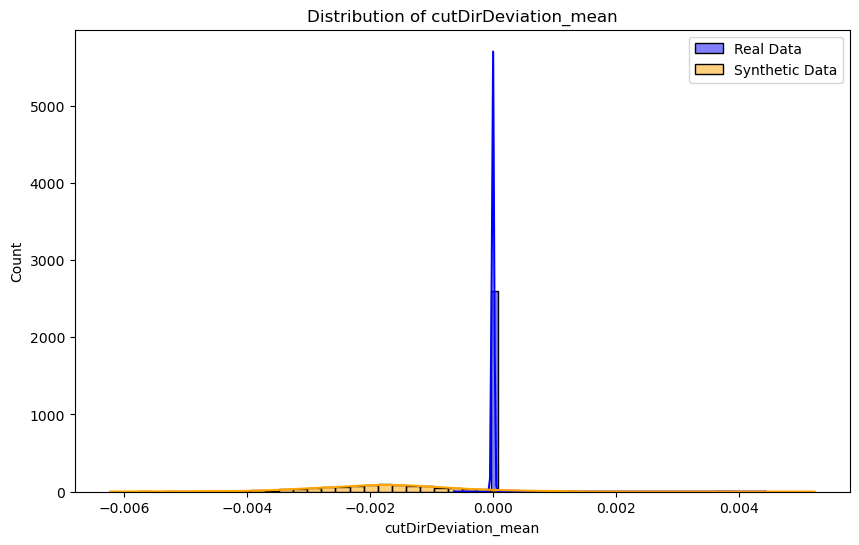

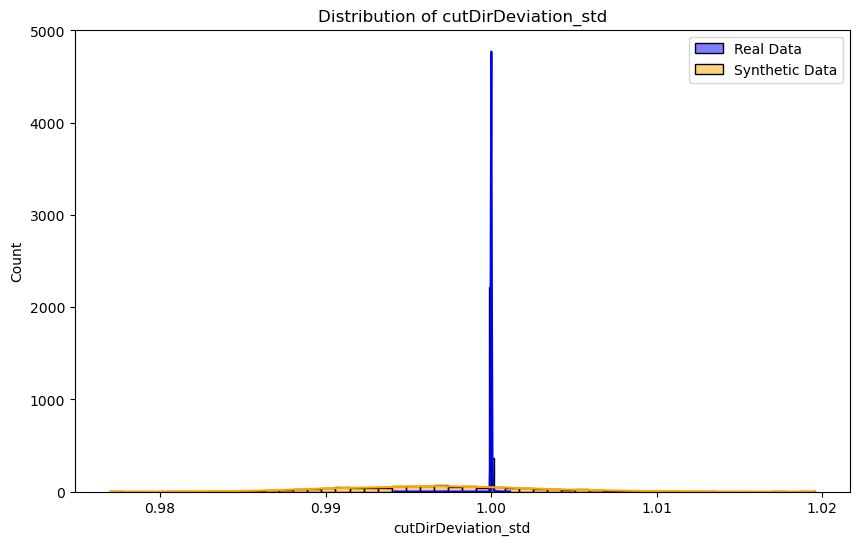

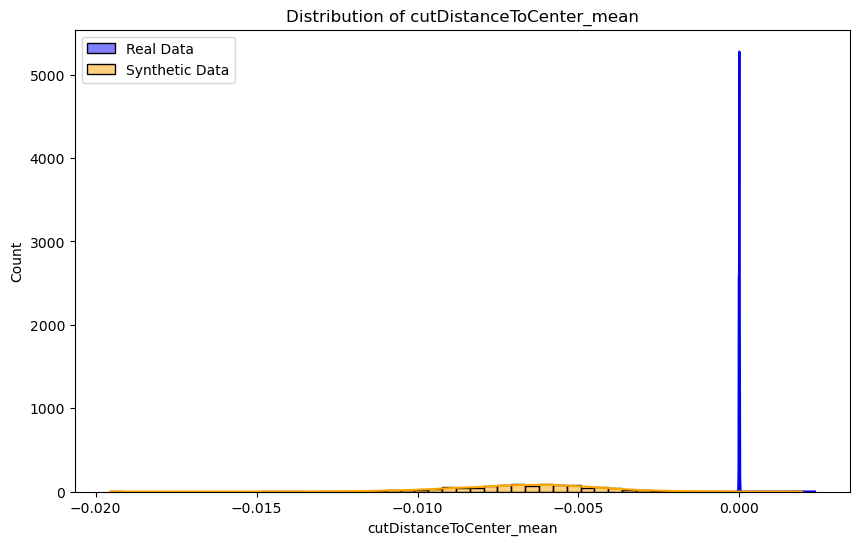

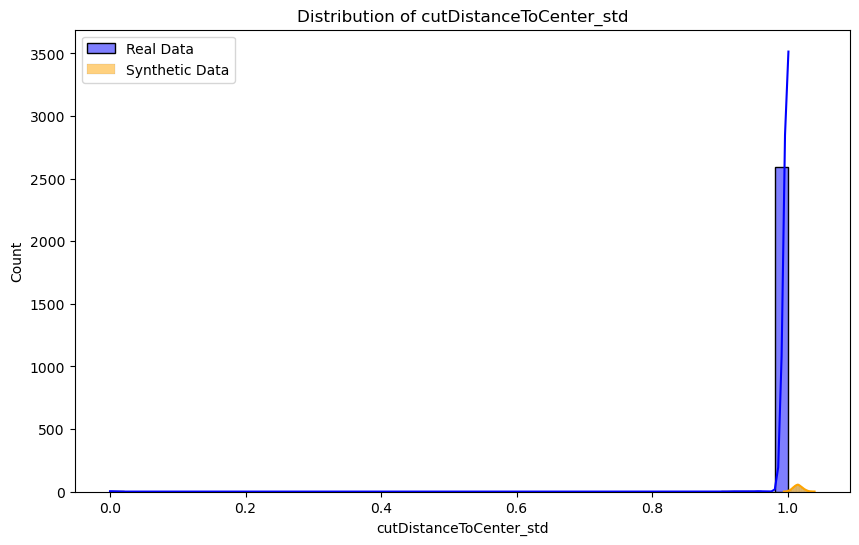

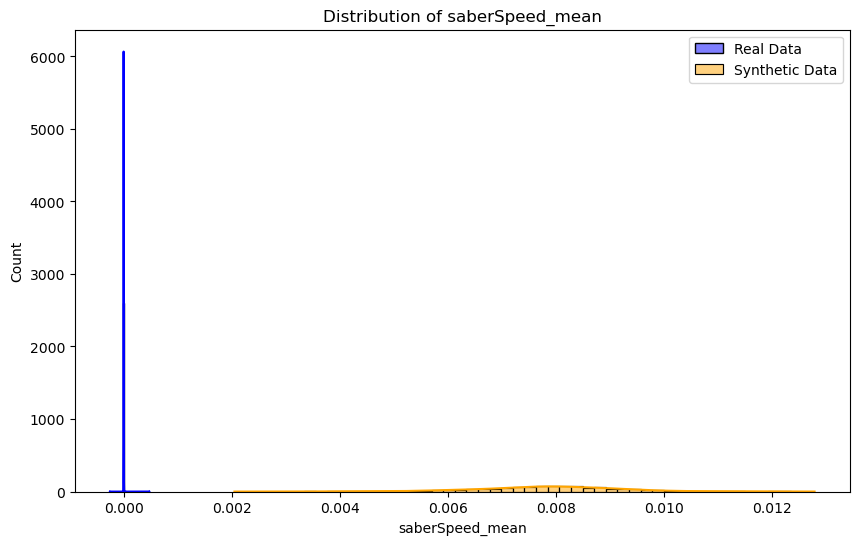

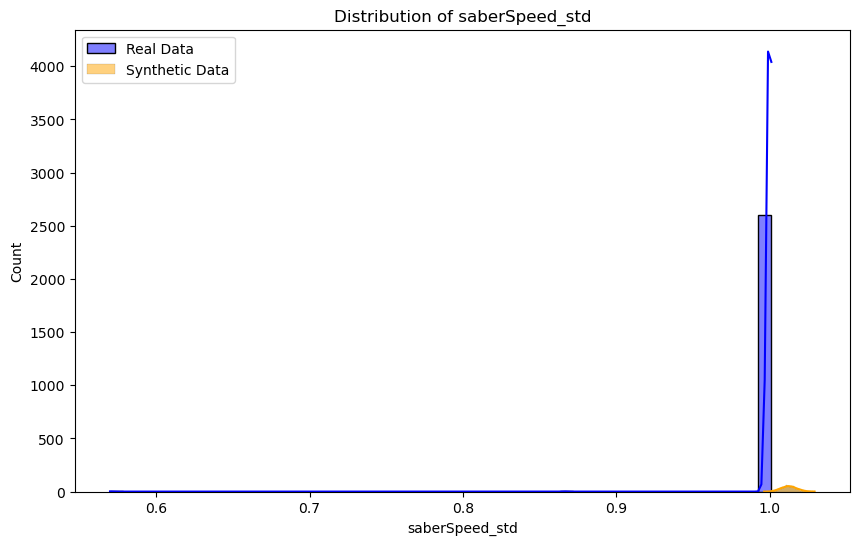

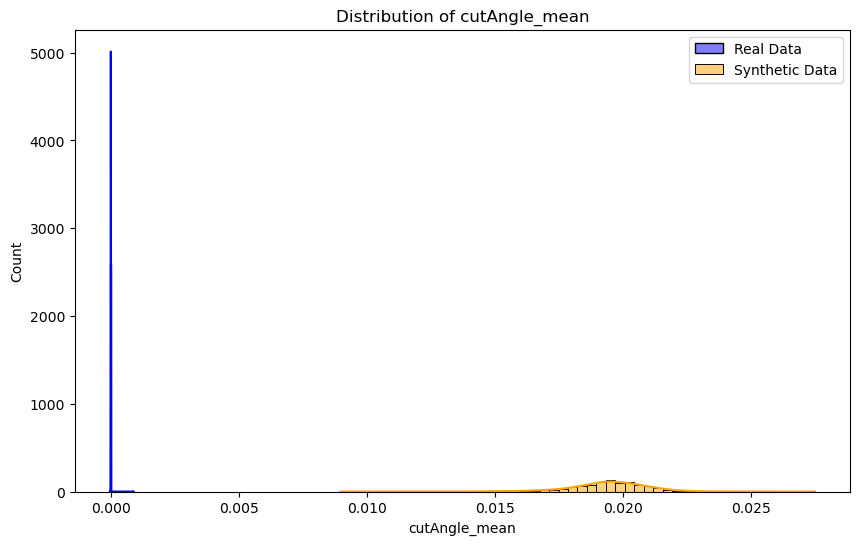

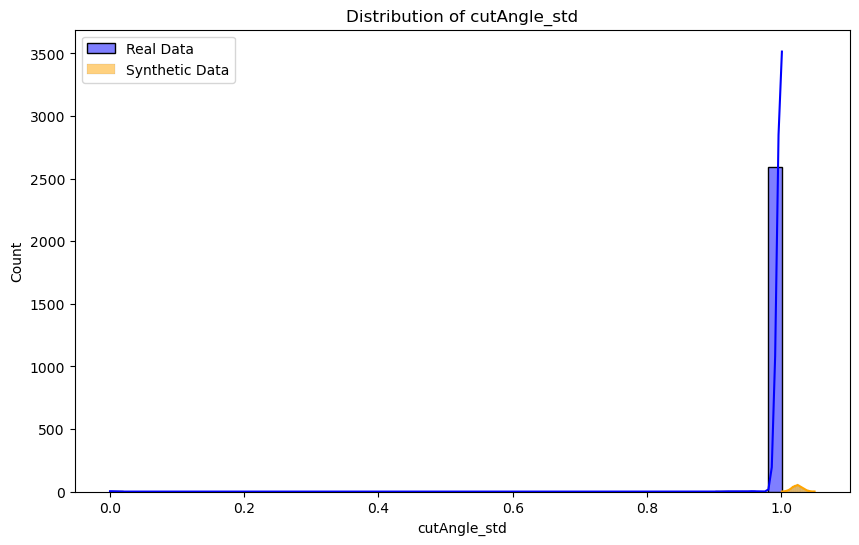

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize each feature in both real and synthetic data
for feature in aggregated_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(real_data[feature], color='blue', label='Real Data', bins=50, kde=True)
    sns.histplot(synthetic_data[feature], color='orange', label='Synthetic Data', bins=50, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.legend()
    plt.show()
